In [1]:
from pathlib import Path
from collections import Counter, defaultdict
from copy import deepcopy
from pickle import dump
from itertools import combinations, permutations, groupby
from pprint import pprint
import matplotlib.pyplot as plt

from tqdm import tqdm

from vdj_walker import *
from sequence import Sequence

%matplotlib inline

In [3]:
data D(gene, J_gene, V_gene)
data Comb(gene, length)
data DGene(read, gene)
data DRead(read, J_gene, V_gene)
data DIndexRead(read, J_gene, V_gene, dataset)
data Kmer(kmer, read)

In [4]:
def get_fa_header_value(line, *, index):
    return line.split('|')[index].split(':')[1]

In [5]:
def read_fa(file):
    next(file)  # skip first '>'
    read = ''
    for line in file:
        if line.startswith('>'):
            yield read
            read = ''
            continue
        read += line

In [8]:
def read_comb(file):  #ToDo: consume read right!
    try:
        while True:
            next(file)
            length = next(file).strip('-').strip() |> len
            gene = next(file) |> get_fa_header_value$(?, index=1)
            next(file)
            yield Comb(gene, length)
    except StopIteration:
        print('hi')
        return
    
vdj_dir_iter()$[0] / 'j_alignments.fa' |> open |> read_comb |> .$[1234]

Comb(gene='IGHJ6*03', length=57)

In [7]:
def read_genes(file):
    try:
        while True:
            gene = next(file)[1:].strip()
            read = next(file).upper().strip()
            yield DGene(read, gene)
    except StopIteration:
        return

In [10]:
def read_V_headers(file):
    length = 0
    for line in file:
        if line.startswith('>'):
            if 'READ' in line:
                length = get_fa_header_value(line, index=3) |> int
            elif 'GENE' in line:
                gene = get_fa_header_value(line, index=1)
                yield Comb(gene, length)

vdj_dir_iter()$[0] / 'v_alignments.fa' |> open |> read_V_headers |> .$[500]

Comb(gene='IGHV1-2*02', length=295)

In [11]:
Ds = open(gene_dir / 'IGHD-allP.fa', 'r') |> read_genes |> list

In [21]:
ds_kmers = set()
for i in Ds:
    for kmer in split_kmers(i.read, 7):
        ds_kmers.add(kmer)

In [12]:
Ds
print(Sequence('GGTACAACTGGAACGAC', 'GGTACAACTGGAACGAC').make_lightweight_matrix())

17


In [13]:
def fetch_d(vdj_dir: Path, i):
    clean_reads = open(vdj_dir / 'cleaned_reads.fasta', 'r') |> read_fa
    Js = open(vdj_dir / 'j_alignments.fa') |> read_comb
    Vs = open(vdj_dir / 'v_alignments.fa') |> read_V_headers
    
    for read, j, v in zip(clean_reads, Js, Vs):
        d_read = read[v.length : (len(read) - j.length)]
        yield DIndexRead(d_read, j.gene, v.gene, i)

In [14]:
def split_kmers(read, size):
    for i in range(len(read) - size + 1):
        yield read[i : i + size]

In [15]:
# for task 3
raw_reads = Counter()
for i, vdj_dir in enumerate(vdj_dir_iter()):
    print(vdj_dir)
    for d in fetch_d(vdj_dir, i):
        raw_reads[d] += 1
    last_compiled = i, vdj_dir

print('HELOOOOOOO')
len(raw_reads)

/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/155/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/157/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/162/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/163/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/4/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/5/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/6/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/8/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/01A/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/01B/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/02A/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/02B/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/03A/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/03B/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/04A/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/04B/igr/vjf
hi
/home/sencho/Projects/bio/v

249127

In [16]:
vj_pairs = Counter()
for read, n in raw_reads.items():
    np = n // 15
    if np > 0:
        vj_pairs[read] = np

len(vj_pairs)

1250

In [52]:
id_kmers = Counter()
for id_read, n in vj_pairs.items():
    for kmer_read in split_kmers(id_read.read, 7):
        id_kmers[Kmer(kmer_read, id_read)
                ] = n
len(id_kmers)

22008

In [53]:
unique_id_kmers = Counter({k: v for k, v in id_kmers.items() 
                           if k.kmer not in ds_kmers})
len(unique_id_kmers)

14896

In [23]:
def ys(xs):
    for i in xs:
        yield i[1]
def colors(xs):
    for i in xs:
        r = i[0]
        #print(r)
        if r in unique_id_kmers:
            yield 'r'
        else:
            yield 'b'
def util_x(kmers):
    for i, (kmer, n) in enumerate(kmers):
        if kmer in unique_id_kmers:
            yield i, (kmer, n)
def unique_plot_y(xs):
    for i, (_, n) in xs:
        yield n
def unique_plot_x(xs):
    for i, info in xs:
        yield i

In [54]:
common_kmers = id_kmers.most_common()[::-1]

In [131]:
dot_xu = util_x(common_kmers) |> list

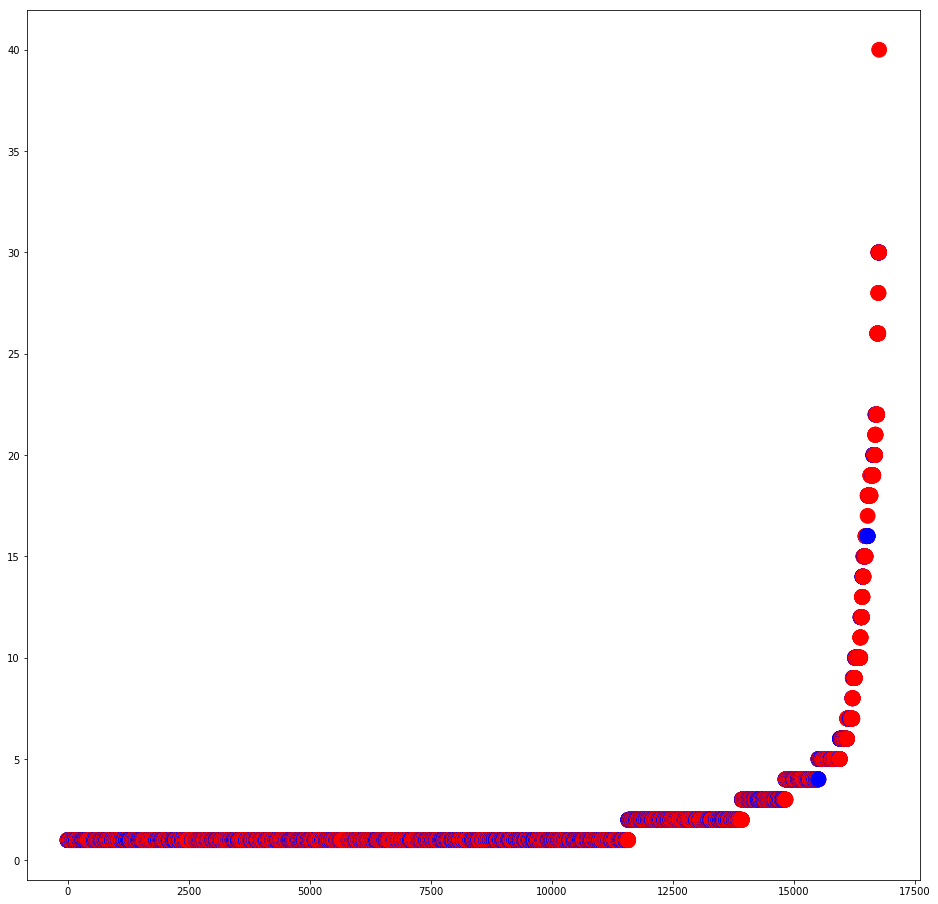

In [177]:
plt.figure(figsize=(16, 16))

plt.scatter(
    range(len(common_kmers)),
    ys(common_kmers) |> list,
    c=colors(common_kmers) |> list,
    s=220
)
"""
plt.scatter(
    unique_plot_x(dot_xu) |> list,
    unique_plot_y(dot_xu) |> list,
    s = 10,
    color='r'
)
"""
plt.show()

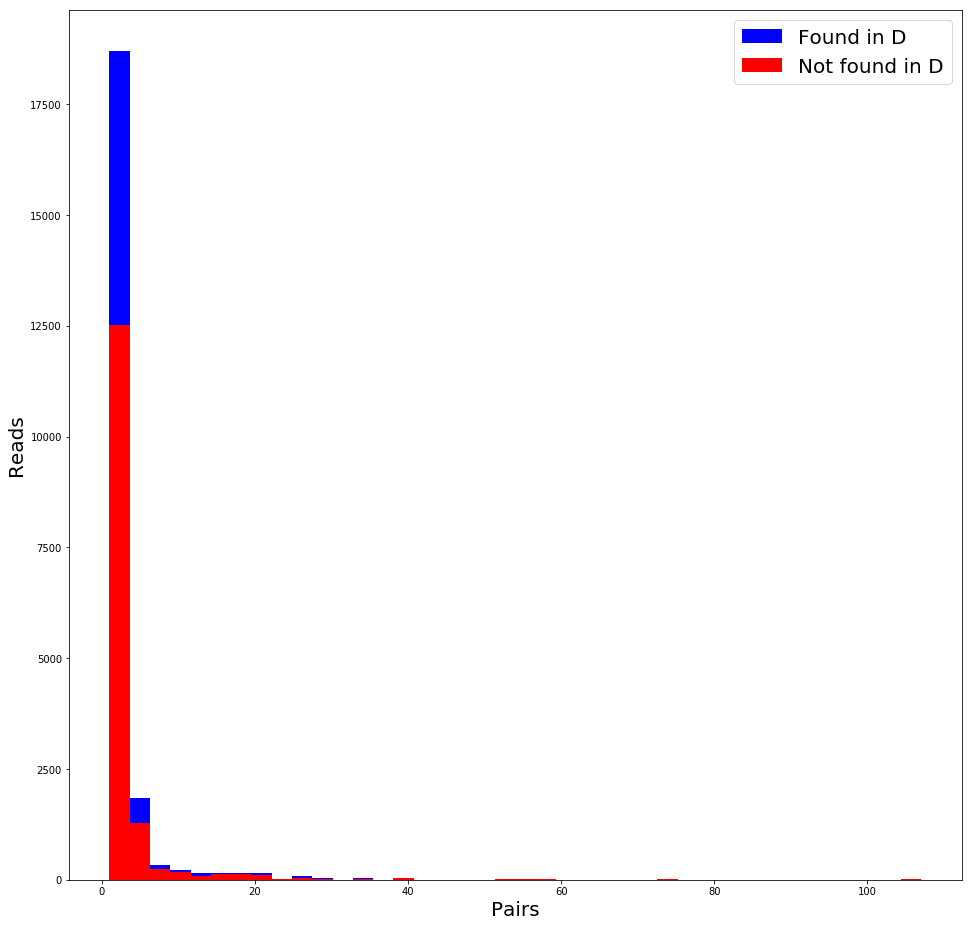

In [55]:
vdj_plot = plt.figure(figsize=(16, 16))

def all_kmers():
    for q, i in common_kmers:
        yield i
        
def unique_kmers():
    for q, i in common_kmers:
        if q in unique_id_kmers:
            yield i

all_ = plt.hist(all_kmers() |> list, 40, alpha=1, color='b', label='Found in D')
unique_ = plt.hist(unique_kmers() |> list, 40, alpha=1, color='r', label='Not found in D')
plt.xlabel('Pairs', fontsize=20)
plt.ylabel('Reads', fontsize=20)
#plt.legend(handles=[all_, unique_])
plt.legend(fontsize=20)

In [49]:
vdj_plot.savefig('vdj_kmers.png')

In [ ]:
cool = 

In [14]:
# for task 2
kmers = defaultdict(set)
kmers_q = Counter()
for i, vdj_dir in enumerate(vdj_dir_iter()):
    print(vdj_dir)
    for d in fetch_d(vdj_dir):  # doesn't work anymore
        #print(d)
        for kmer in split_kmers(d.read, 7):
            kmers_q[kmer] += 1
            kmers[kmer].add(d)
    last_compiled = i, vdj_dir

print('HELOOOOOOO')
len(kmers)

/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/155/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/157/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/162/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/163/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/4/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/5/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/6/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Dnr/8/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/01A/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/01B/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/02A/igr/vjf
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/02B/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/03A/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/03B/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/04A/igr/vjf
hi
/home/sencho/Projects/bio/vdj_data/rep_seq/Twins/04B/igr/vjf
hi
/home/sencho/Projects/bio/v

16564

In [ ]:
# for first task
d_genes = Counter()
for i, vdj_dir in enumerate(vdj_dir_iter()$[:1]):
    print(vdj_dir)
    for d in fetch_d(vdj_dir):  # dont work anymore
        d_genes[d] += 1
    last_compiled = i, vdj_dir

In [ ]:
# for first task
gene_iter = ((Sequence(d.read, chosen_d_read).make_lightweight_matrix(), d) for d in Ds)
gene = max(gene_iter, key=.[0])[1]
print(gene)
gene = gene.gene

In [17]:
check = 0
dn = 0
for d in vdj_dir_iter():
    dn += 1
    for l in read_fa(open(d / 'cleaned_reads.fasta')):
        check += 1

In [18]:
check / 2

185233.5

In [19]:
dn

18

In [21]:
unique = {key: kmers[key] for key, val in kmers_q.items()
          if val >= 2000 and key not in ds_kmers}
len(unique)

221

In [22]:
n = 0
for v in unique.values():
    for a in v:
        n += 1
n

384659

In [80]:
read_kmers = defaultdict(set)
for kmer, reads in unique.items():
    for read in reads:
        read_kmers[read].add(kmer)
len(read_kmers)

147406

In [81]:
read_kmers = filter((x)->len(x[1]) > 5, read_kmers.items()) |> dict
len(read_kmers)

13471

In [82]:
read_counter = Counter()
for read in read_kmers.keys():
    read_counter[read.read] += 1
len(read_counter)

11767

In [83]:
read_counter = {k: v for k,v in read_counter.items() if v > 1}
len(read_counter)

828

In [84]:
read_kmers = {k: v for k, v in read_kmers.items() if k.read in read_counter}
len(read_kmers)

2532

In [30]:
def join_neighbors(k1, k2, s):
    mlen = min(len(k1), len(k2))
    p1 = k1[len(k1) - mlen + s:]
    p2 = k2[:mlen - s]
    if p1 == p2:
        return k1 + k2[mlen - s:]
    return False

In [31]:
def join_all_neighbors(kmers, s=1):
    for k1, k2 in permutations(kmers, r=2):
        t = join_neighbors(k1, k2, 1)
        if t:
            new_kmers = kmers - set((k1, k2))
            new_kmers.add(t)
            return join_all_neighbors(new_kmers, s=s)  # tail recursion opt, so no worry
    return kmers

In [33]:
join_neighbors('BAAAC', 'AAACB', s=1)

'BAAACB'

In [34]:
def read_kmers_iter(read_kmers):
    for kmers in read_kmers.values():
        yield from kmers

In [35]:
def count_kmers(read_kmers):
    n = 0
    for kmer in read_kmers_iter(read_kmers):
        n += 1
    return n

In [85]:
read_kmers_clear = deepcopy(read_kmers)

In [ ]:
read_kmers = read_kmers_clear

In [87]:
count_kmers(read_kmers) |> print
read_kmers = {read: join_all_neighbors(kmers, s=1) for read, kmers in read_kmers.items()}
count_kmers(read_kmers) |> print

21586
18233


In [45]:
def coverage(read, kmers):
    

Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/coconut/icoconut/root.py", line 70, in memoized_parse_block
    result = parse_block_memo[code]
KeyError: 'def coverage(read, kmers):\n    \n'

During handling of the above exception, another exception occurred:

pyparsing.ParseException: Expected end of text (at char 0), (line:1, col:1)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/coconut/compiler/compiler.py", line 483, in parse
    parsed = parse(parser, pre_procd)
  File "/usr/lib/python3.6/site-packages/coconut/compiler/util.py", line 190, in parse
    return grammar.parseWithTabs().parseString(text)
  File "/usr/lib/python3.6/site-packages/pyparsing.py", line 1632, in parseString
    raise exc
  File "/usr/lib/python3.6/site-packages/pyparsing.py", line 1622, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "/usr/lib/python3.6/site-packag

SyntaxError: parsing failed
  def coverage(read, kmers): (<string>)

In [43]:
def group_intersections(kmers, level=0):
    intersecting = find_intersecting_kmers(kmers)
    #intersecting = filter((x)->len(x[1]) > 100, intersecting) |> 
    #intersecting = filter((x)->not neighbors(*x[0]), intersecting)
    #print('Making dict of intersecting...')
    # Build dict
    intersect_dict = defaultdict(dict)
    for (k1, k2), reads in intersecting:
        intersect_dict[k1][k2] = reads
        #intersect_dict[k2][k1] = reads
    #print(' ' * level + f'level {level}: {len(intersect_dict)}')
    #if level:
    #pprint(dict(intersect_dict))
        
    for kmer, intersect_kmers in intersect_dict.items():
        if len(intersect_kmers) > 1:
            #print(' '*level + kmer)
            intersect_dict[kmer] = group_intersections(intersect_kmers, level=level+1)
            #pprint(dict(intersect_kmers))
            #pprint(dict(intersect_dict[kmer]))
        
    #print(' ' * level + f'level {level} done!')
    return intersect_dict

In [44]:
print(len(unique))
test = {
    'a': {1, 2, 3},
    'b': {2, 3, 4},
    'c': {3, 4, 5},
    'd': {4, 5, 6}
}
fin = group_intersections(
#unique)
test)

221


In [45]:
fin

defaultdict(dict,
            {'a': defaultdict(dict, {'b': {'c': {3}}}),
             'b': defaultdict(dict, {'c': {'d': {4}}}),
             'c': {'d': {4, 5}}})

In [46]:
def print_tree(kmers, level=0):
    if kmers `isinstance` set:
        return
    for kmer, leaves in kmers.items():
        print('-' * level, kmer, sep='')
        print_tree(leaves, level=level+1)
print_tree(fin)

a
-b
--c
b
-c
--d
c
-d


In [ ]:
kmer_reads(kmers)$[0]
all_len = kmer_reads(kmers) |> map$((x)->len(x)) |> sum
n = 0
for read in kmer_reads(kmers): n += 1
all_len / n  # average length

In [ ]:
kmers |> len

In [31]:
del fin